In [466]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Lasso
import warnings
import seaborn as sns
from scipy.optimize import minimize

<h1>Hyperparameters<h1>


In [467]:
K = 5 # validation folds
MIN_LAG = 120
MAX_LAG = 168
SEED = 42
VAL_SPLIT = 0.2

In [468]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

<h1>Creating DataFrames<h1>

In [469]:
spot_prices = pd.read_csv("spotpriser.csv").set_index("time")
consumption = pd.read_csv("consumption_temp_with_flags.csv").set_index("time")

oslo_consumption = consumption[consumption["location"] == "oslo"]
oslo_consumption = oslo_consumption.merge(spot_prices["oslo"], left_index=True, right_index=True, how="left")
oslo_consumption=oslo_consumption.drop(['location'],axis=1).rename(columns={'oslo':'spot_price'})

stavanger_consumption = consumption[consumption["location"] == "stavanger"]
stavanger_consumption = stavanger_consumption.merge(spot_prices["stavanger"], left_index=True, right_index=True, how="left")
stavanger_consumption=stavanger_consumption.drop(['location'],axis=1).rename(columns={'stavanger':'spot_price'})

trondheim_consumption = consumption[consumption["location"] == "trondheim"]
trondheim_consumption = trondheim_consumption.merge(spot_prices["trondheim"], left_index=True, right_index=True, how="left")
trondheim_consumption=trondheim_consumption.drop(['location'],axis=1).rename(columns={'trondheim':'spot_price'})

tromso_consumption = consumption[consumption["location"] == "tromsø"]
tromso_consumption = tromso_consumption.merge(spot_prices["tromsø"], left_index=True, right_index=True, how="left")
tromso_consumption=tromso_consumption.drop(['location'],axis=1).rename(columns={'tromsø':'spot_price'})

bergen_consumption = consumption[consumption["location"] == "bergen"]
bergen_consumption = bergen_consumption.merge(spot_prices["bergen"], left_index=True, right_index=True, how="left")
bergen_consumption=bergen_consumption.drop(['location'],axis=1).rename(columns={'bergen':'spot_price'})
    

<h1>Feature engineering<h1>

In [470]:
DFS = [oslo_consumption,stavanger_consumption,trondheim_consumption,tromso_consumption,bergen_consumption]
DF_STRINGS = ["Oslo","Stavanger","Trondheim","Tromsø","Bergen"]

cols_to_standard_normal = ["temperature","consumption"]
cols_to_normalize_01 = ["consumption","spot_price"]
columns_to_decompose = ['temperature', 'spot_price','consumption']
cols_to_diff = []
REVERSE_CONSUMPTION_NORMALIZATION = [] #note: Same order as consumption_dfs

In [471]:
def lag_columns(df, min_lag,max_lag, columns):
    for col in columns:
        if col in df.columns:
            for lag in range(min_lag,max_lag+1):
                df[f"{col}_L{lag}"] =  df[col].shift(lag)
            if col not in ['consumption_seasonal', 'consumption_trend']:
                df.drop(col, axis=1) 
    return df.dropna(axis=0)


def decompose_time_series(df, columns_to_decompose=columns_to_decompose, period=24):
    for col in columns_to_decompose:
        if col in df.columns:
            # Decompose the time series
            result = seasonal_decompose(df[col], model='additive', period=period)

            # Create new columns for trend and seasonal components
            df[f"{col}_trend"] = result.trend
            df[f"{col}_seasonal"] = result.seasonal

            # Drop the original column
            df.drop(col, axis=1, inplace=True)
        else:
            print(f"Column '{col}' not found in DataFrame.")
    
    return df

def add_interaction_column(df,col1, col2):
    df[f"{col1}_X_{col2}"] = df[col1]*df[col2]
    return df.dropna() 

In [472]:
for i in range(len(DFS)):
    DFS[i].dropna(axis=0, inplace=True)
    DFS[i]["is_holiday"] = DFS[i]["is_holiday"].astype(int)
    DFS[i]["is_weekend"] = DFS[i]["is_weekend"].astype(int)
    DFS[i].index = pd.to_datetime(DFS[i].index)
    DFS[i]["hour"] = np.cos(DFS[i].index.hour*np.pi/12)
    DFS[i]["month"] = np.cos(DFS[i].index.month*np.pi/6)

    for col in cols_to_standard_normal:
        mu, sig = DFS[i][col].mean(), DFS[i][col].std()
        if col == "consumption":
            REVERSE_CONSUMPTION_NORMALIZATION.append([mu,sig])
        DFS[i][col] = (DFS[i][col]-mu)/sig
    for col in cols_to_normalize_01:
        DFS[i][col] = (DFS[i][col]-DFS[i][col].min())/(DFS[i][col].max()-DFS[i][col].min())
    DFS[i] = decompose_time_series(DFS[i])
    DFS[i] = lag_columns(DFS[i], min_lag=24,max_lag = MAX_LAG, columns=["temperature_trend", "temperature_seasonal", "spot_price_trend", "spot_price_seasonal"])
    DFS[i] = lag_columns(DFS[i], min_lag=MIN_LAG,max_lag = MAX_LAG, columns=["consumption_trend","consumption_seasonal"])
    DFS[i] = add_interaction_column(DFS[i], "hour", "is_weekend")
    DFS[i] = add_interaction_column(DFS[i], "month", "is_weekend")
    DFS[i] = add_interaction_column(DFS[i], "hour", "is_holiday")
    DFS[i] = add_interaction_column(DFS[i], "month", "is_holiday")
    DFS[i] = DFS[i].dropna(axis=0)


/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_38963/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_38963/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_38963/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

<h1>Training<h1>

In [473]:
# k-Fold for validation
k = K
np.random.seed(SEED)


def avoid_spillover_split(X,offset):
    length = len(X)
    indices = np.arange(offset, length+1, MAX_LAG+1)
    return X.iloc[indices]

def custom_train_val_split(data, val_split):
    thresh = np.floor(len(data) * (1 - val_split)).astype(int)
    return data.iloc[:thresh], data.iloc[thresh:]

In [474]:
eps = 2**(-30)

def soft_abs(z):
    return np.sqrt(z**2+eps)

# Lasso with MAPE Loss
def lasso_mape_loss(w, X, y_true, alpha):
   
    y_pred = X @ w
    return np.mean(soft_abs((y_true - y_pred)/(y_true+1))) + alpha * np.sum(soft_abs(w))/np.mean(y_true+1)

In [475]:

def cross_validate(data,alpha1,alpha2,mu,sig,MAPEfac,initVarianceFac):
    # Lasso with MAPE Loss
    def lasso_mape_loss(w, X, y_true, alpha):
    
        y_pred = X @ w
        return np.mean(soft_abs((y_true - y_pred)/(y_true+MAPEfac))) + alpha * np.sum(soft_abs(w))/np.mean(y_true+MAPEfac)
    mape_values = []
    L = len(data)
    offsets = range(1,L,int(np.floor(L/k)))
    for offset in offsets:
        X = data.iloc[offset:int(offset + np.floor(L/k))]
        y1 = X["consumption_seasonal"]
        y2 = X["consumption_trend"]
        X = X.drop(columns = ["consumption_seasonal","consumption_trend"])
        X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
        y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
        y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)
        
        tol = 1e-5
        n_features = X_train.shape[1]
        w_initial = np.random.randn(n_features)/initVarianceFac  # Random initialize
        result = minimize(lasso_mape_loss, w_initial, args=(X_train, y1_train, alpha1), method='L-BFGS-B', options={'tol': tol})
        w_optimal = result.x
        y1_pred = X_val @ w_optimal

        result = minimize(lasso_mape_loss, w_initial, args=(X_train, y2_train, alpha2), method='L-BFGS-B', options={'tol': tol})
        w_optimal = result.x
        y2_pred = X_val @ w_optimal

        mape = np.mean(np.abs(((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val)*sig+mu))) * 100
        mape_values.append(mape)
    average_mape = np.mean(mape_values)
    return average_mape

Oslo
Alpha1, alpha2, MAPEfac, initVarianceFac --> MAPE
9.5367431640625e-07 0.000244140625 0.1 50 --> 1.937585300823638
9.5367431640625e-07 0.000244140625 0.1 100 --> 1.5015298990646297
9.5367431640625e-07 0.000244140625 0.1 500 --> 1.6517385711596262
9.5367431640625e-07 0.000244140625 1 50 --> 1.896601411797675
9.5367431640625e-07 0.000244140625 1 100 --> 1.626007518590485
9.5367431640625e-07 0.000244140625 1 500 --> 1.4834168880851086
9.5367431640625e-07 0.000244140625 10 50 --> 2.206563544331483
9.5367431640625e-07 0.000244140625 10 100 --> 2.159563218891466
9.5367431640625e-07 0.000244140625 10 500 --> 1.761124792816469
9.5367431640625e-07 0.000244140625 100 50 --> 2.3603230661507935
9.5367431640625e-07 0.000244140625 100 100 --> 1.3500853365884014
9.5367431640625e-07 0.000244140625 100 500 --> 1.8580822668501304
9.5367431640625e-07 0.00048828125 0.1 50 --> 2.025125169172672
9.5367431640625e-07 0.00048828125 0.1 100 --> 1.2964460800267856
9.5367431640625e-07 0.00048828125 0.1 500 --

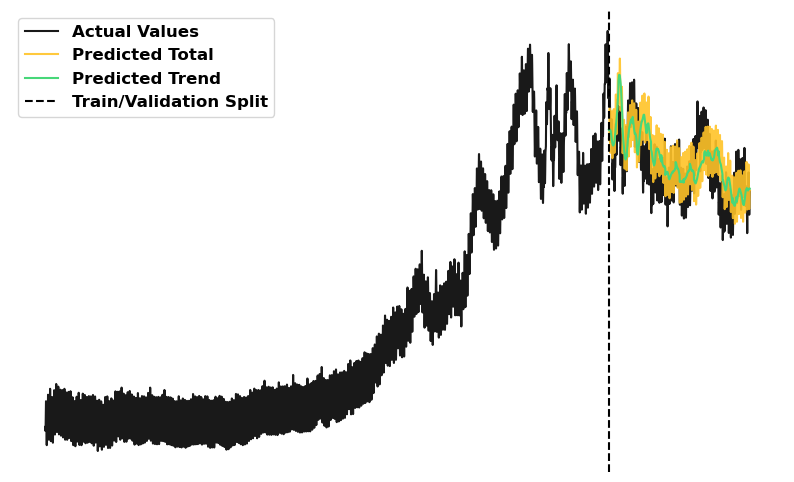

Error95: 0.05212172055269108
Out of sample MAPE: 2.299447971827542
Mean oveprediction: 2.5366125917806883
Mean underprediction: 1.8373567639117134
MAPE with trend prediction only: 2.5419804805647304
Coefficients: 
is_holiday: 0.03703376775969562
is_weekend: 0.0621467933443086
hour: 0.0019491269408487733
month: 0.07833830377824538
temperature_trend: -0.06070443613550221
temperature_seasonal: -0.02808238158033613
spot_price_trend: -0.002244380568297948
spot_price_seasonal: 0.0053885112634576085
temperature_trend_L24: -0.01123974858816191
temperature_trend_L25: -0.017169121405199727
temperature_trend_L26: -0.0196691339377429
temperature_trend_L27: -0.02106487070453294
temperature_trend_L28: -0.024673128502362886
temperature_trend_L29: -0.015074389123608858
temperature_trend_L30: -0.0009582037111603173
temperature_trend_L31: 0.0067303586765754125
temperature_trend_L32: -0.006643781883060532
temperature_trend_L33: -0.005374756733155913
temperature_trend_L34: 0.0029695537703827136
temperatur

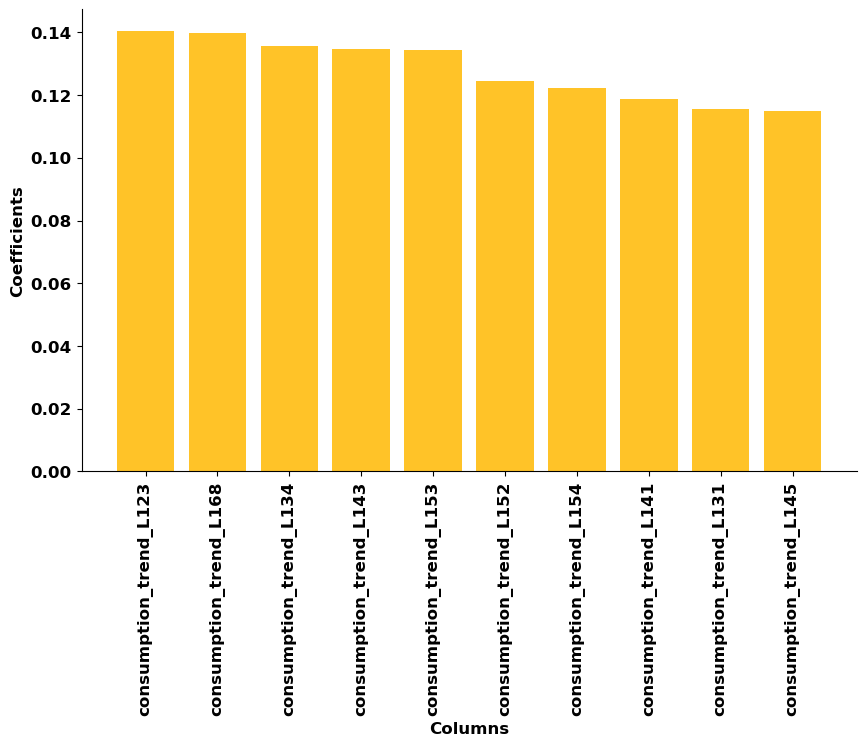

Stavanger
Alpha1, alpha2, MAPEfac, initVarianceFac --> MAPE
9.5367431640625e-07 0.000244140625 0.1 50 --> 2.357694209680845
9.5367431640625e-07 0.000244140625 0.1 100 --> 1.6890930217638256
9.5367431640625e-07 0.000244140625 0.1 500 --> 2.19804886207897
9.5367431640625e-07 0.000244140625 1 50 --> 1.9614103771263536
9.5367431640625e-07 0.000244140625 1 100 --> 1.9417826895060792
9.5367431640625e-07 0.000244140625 1 500 --> 1.681191489642846
9.5367431640625e-07 0.000244140625 10 50 --> 2.1238090103064757
9.5367431640625e-07 0.000244140625 10 100 --> 1.9486818970620068
9.5367431640625e-07 0.000244140625 10 500 --> 1.6853823421960061
9.5367431640625e-07 0.000244140625 100 50 --> 2.079034583110351
9.5367431640625e-07 0.000244140625 100 100 --> 1.811434081388385
9.5367431640625e-07 0.000244140625 100 500 --> 1.6802573717120317
9.5367431640625e-07 0.00048828125 0.1 50 --> 2.3949730597980965
9.5367431640625e-07 0.00048828125 0.1 100 --> 1.79170889611479
9.5367431640625e-07 0.00048828125 0.1 50

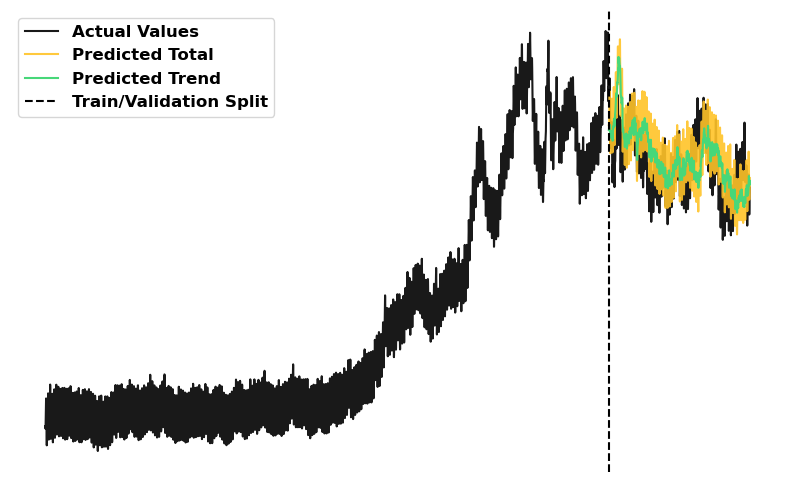

Error95: 0.05256482594174453
Out of sample MAPE: 2.4108217312072493
Mean oveprediction: 2.662158383200073
Mean underprediction: 1.8374755468592654
MAPE with trend prediction only: 2.484511456709681
Coefficients: 
is_holiday: 0.023567363729790992
is_weekend: 0.018047881378841894
hour: -0.07502597931855363
month: 0.04399058957779975
temperature_trend: -0.02893682912821041
temperature_seasonal: 0.07405194082864106
spot_price_trend: 0.03535285033808868
spot_price_seasonal: 0.01295028408377776
temperature_trend_L24: 0.03525197780750731
temperature_trend_L25: 0.024100276539267558
temperature_trend_L26: -0.04871162898867047
temperature_trend_L27: -0.05403621895776662
temperature_trend_L28: -0.025804322998850673
temperature_trend_L29: -0.019457079109218234
temperature_trend_L30: -0.07948151750304362
temperature_trend_L31: 0.10287170622580101
temperature_trend_L32: 0.018635771261985703
temperature_trend_L33: -0.035293152823334575
temperature_trend_L34: 0.0031827479458520678
temperature_trend_L3

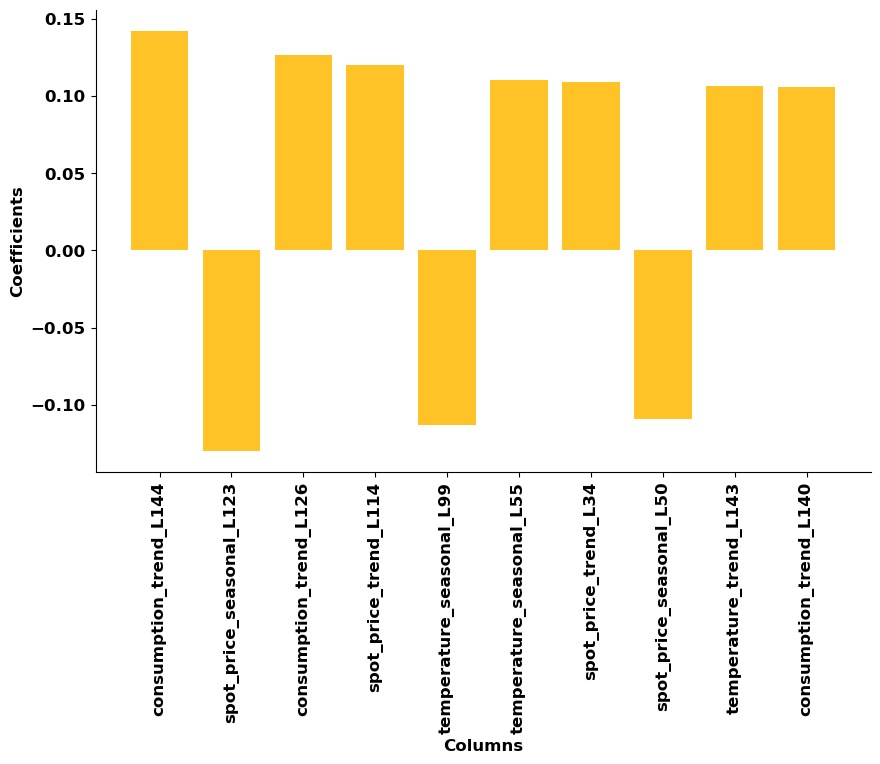

Trondheim
Alpha1, alpha2, MAPEfac, initVarianceFac --> MAPE
9.5367431640625e-07 0.000244140625 0.1 50 --> 1.5929260639238134
9.5367431640625e-07 0.000244140625 0.1 100 --> 1.5392658999805429
9.5367431640625e-07 0.000244140625 0.1 500 --> 1.4786264497498947
9.5367431640625e-07 0.000244140625 1 50 --> 1.3597406228158369
9.5367431640625e-07 0.000244140625 1 100 --> 1.2754230095398993
9.5367431640625e-07 0.000244140625 1 500 --> 1.3992175804972002
9.5367431640625e-07 0.000244140625 10 50 --> 1.3656586628532783
9.5367431640625e-07 0.000244140625 10 100 --> 1.3963501417502733
9.5367431640625e-07 0.000244140625 10 500 --> 1.2957012910978698
9.5367431640625e-07 0.000244140625 100 50 --> 1.6654644249502273
9.5367431640625e-07 0.000244140625 100 100 --> 1.3009312020222532
9.5367431640625e-07 0.000244140625 100 500 --> 1.1944335812757463
9.5367431640625e-07 0.00048828125 0.1 50 --> 1.3431358430713622
9.5367431640625e-07 0.00048828125 0.1 100 --> 1.5109276414743211
9.5367431640625e-07 0.0004882812

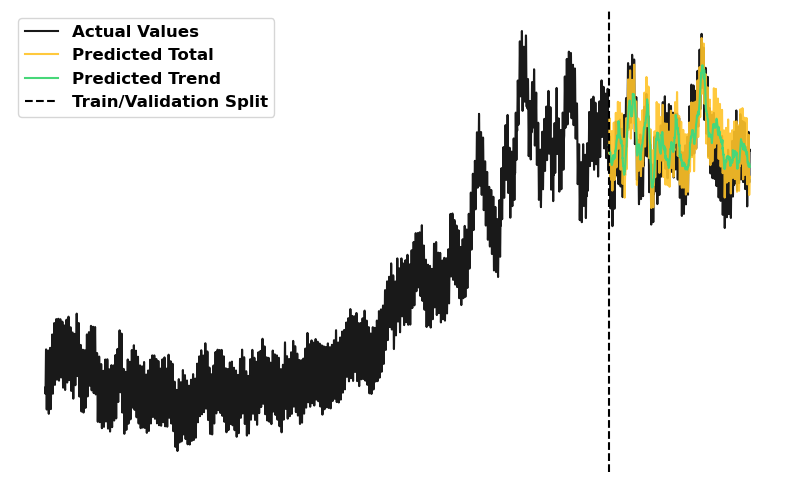

Error95: 0.03000113738028306
Out of sample MAPE: 1.434017340757107
Mean oveprediction: 1.5808381145689134
Mean underprediction: 1.159205493761005
MAPE with trend prediction only: 1.967482816685872
Coefficients: 
is_holiday: 0.004806829989788595
is_weekend: 0.01830334807593633
hour: 0.013858815209677803
month: 0.012833141853080628
temperature_trend: -0.03608230292235413
temperature_seasonal: -0.009180950665098137
spot_price_trend: 0.01807985651246508
spot_price_seasonal: -0.012211421187203255
temperature_trend_L24: -0.03776073146095195
temperature_trend_L25: 0.008189087005354001
temperature_trend_L26: -0.02623105094766395
temperature_trend_L27: 0.03661604441900159
temperature_trend_L28: -0.04736645204533046
temperature_trend_L29: 0.011569536393508014
temperature_trend_L30: -0.015009131194920824
temperature_trend_L31: -0.0030596407182597526
temperature_trend_L32: -0.01334683985308441
temperature_trend_L33: 0.013407547330360316
temperature_trend_L34: 0.007210407398517232
temperature_trend

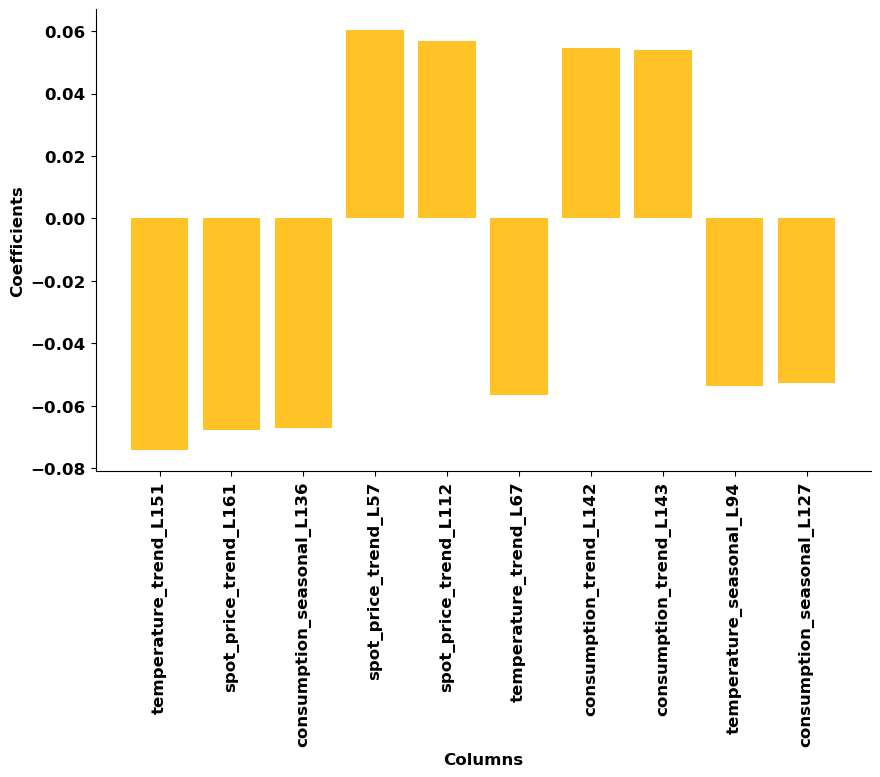

Tromsø
Alpha1, alpha2, MAPEfac, initVarianceFac --> MAPE
9.5367431640625e-07 0.000244140625 0.1 50 --> 2.202306207905356
9.5367431640625e-07 0.000244140625 0.1 100 --> 1.9237689380733642
9.5367431640625e-07 0.000244140625 0.1 500 --> 1.8327465271544134
9.5367431640625e-07 0.000244140625 1 50 --> 2.0925107095016813
9.5367431640625e-07 0.000244140625 1 100 --> 1.5377283306190193
9.5367431640625e-07 0.000244140625 1 500 --> 1.5893463942778152
9.5367431640625e-07 0.000244140625 10 50 --> 1.8210443262456313
9.5367431640625e-07 0.000244140625 10 100 --> 1.7846147558502268
9.5367431640625e-07 0.000244140625 10 500 --> 1.6168084670861735
9.5367431640625e-07 0.000244140625 100 50 --> 2.1237266302726874
9.5367431640625e-07 0.000244140625 100 100 --> 1.7037984841747433
9.5367431640625e-07 0.000244140625 100 500 --> 1.8321763067733698
9.5367431640625e-07 0.00048828125 0.1 50 --> 1.9791323183572616
9.5367431640625e-07 0.00048828125 0.1 100 --> 1.8412739099417148
9.5367431640625e-07 0.00048828125 0.

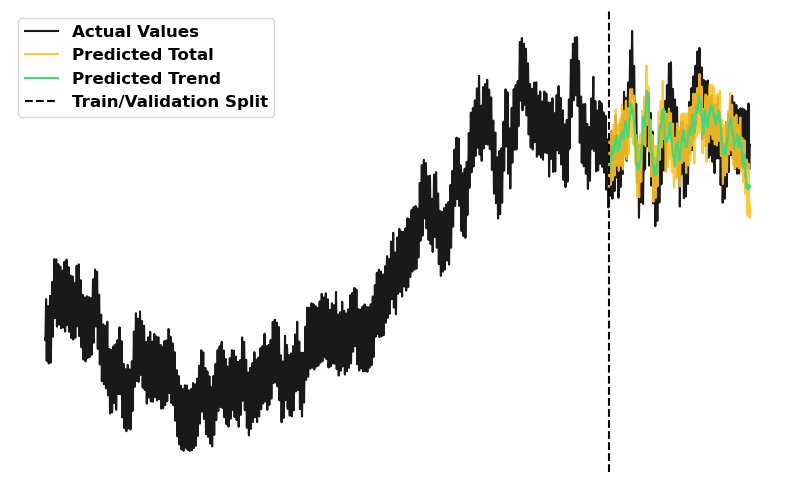

Error95: 0.03521678961441175
Out of sample MAPE: 1.4791468152011293
Mean oveprediction: 1.3477390197255803
Mean underprediction: 1.619917416104311
MAPE with trend prediction only: 1.8630378274494659
Coefficients: 
is_holiday: 0.005926940244602312
is_weekend: 0.001949253675968191
hour: -0.014237819131751277
month: 0.010818429243376946
temperature_trend: -0.02391902657128401
temperature_seasonal: 0.020291553670530385
spot_price_trend: 0.022325230768685995
spot_price_seasonal: 0.025654673890404704
temperature_trend_L24: -0.023406829997150665
temperature_trend_L25: -0.016114711525440858
temperature_trend_L26: 0.0016973417219739472
temperature_trend_L27: -0.0007188483612931442
temperature_trend_L28: 0.006369875483611856
temperature_trend_L29: 0.0052506925671122195
temperature_trend_L30: -0.0018836537513911439
temperature_trend_L31: 0.010784731699708509
temperature_trend_L32: 0.013660924056878264
temperature_trend_L33: -0.008234103452563694
temperature_trend_L34: -0.024124675700825392
temper

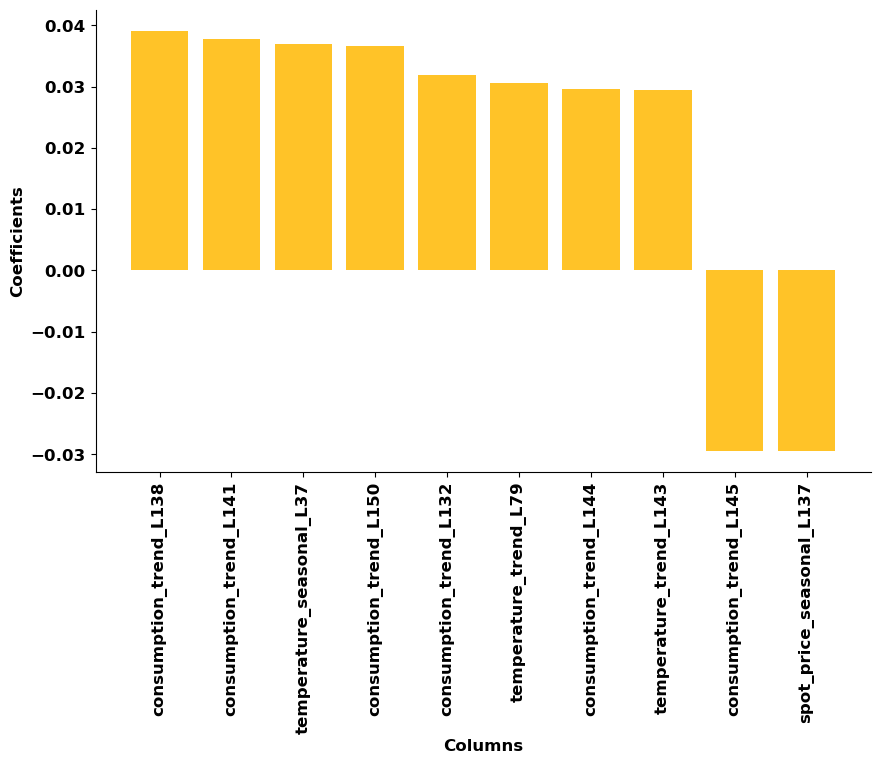

Bergen
Alpha1, alpha2, MAPEfac, initVarianceFac --> MAPE
9.5367431640625e-07 0.000244140625 0.1 50 --> 1.8082208286653405
9.5367431640625e-07 0.000244140625 0.1 100 --> 2.3701870310954343
9.5367431640625e-07 0.000244140625 0.1 500 --> 2.240554371431845
9.5367431640625e-07 0.000244140625 1 50 --> 3.32632651097272
9.5367431640625e-07 0.000244140625 1 100 --> 2.399787424410434
9.5367431640625e-07 0.000244140625 1 500 --> 2.5395922909790385
9.5367431640625e-07 0.000244140625 10 50 --> 2.2085425678500386
9.5367431640625e-07 0.000244140625 10 100 --> 3.057296335617715
9.5367431640625e-07 0.000244140625 10 500 --> 2.196266419171992
9.5367431640625e-07 0.000244140625 100 50 --> 2.5090752976215085
9.5367431640625e-07 0.000244140625 100 100 --> 2.2777262438409247
9.5367431640625e-07 0.000244140625 100 500 --> 2.175683880055081
9.5367431640625e-07 0.00048828125 0.1 50 --> 2.6212878678096674
9.5367431640625e-07 0.00048828125 0.1 100 --> 2.414630203684207
9.5367431640625e-07 0.00048828125 0.1 500 -

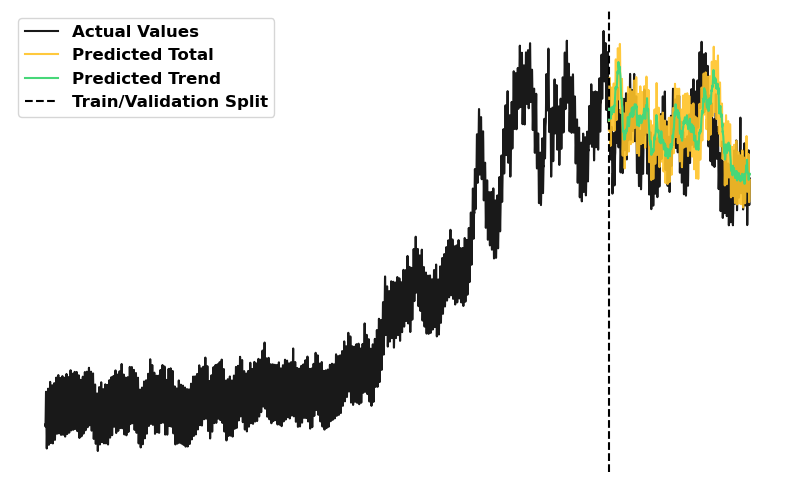

Error95: 0.059654780851182344
Out of sample MAPE: 2.5679833630839637
Mean oveprediction: 2.9585008395483503
Mean underprediction: 1.7375811065266729
MAPE with trend prediction only: 3.009288327065701
Coefficients: 
is_holiday: 0.03028407321051387
is_weekend: 0.014701119992023079
hour: -0.03209743996282711
month: 0.013378933038923188
temperature_trend: -0.00684123112531655
temperature_seasonal: -0.02230899909080382
spot_price_trend: 0.005537572130741637
spot_price_seasonal: 0.021806276808062974
temperature_trend_L24: -0.012758129463235771
temperature_trend_L25: 0.004979563244108218
temperature_trend_L26: -0.0037084690869041877
temperature_trend_L27: -0.017387463202863756
temperature_trend_L28: 0.004848253575263725
temperature_trend_L29: -0.006489765685617363
temperature_trend_L30: -0.009489475915975527
temperature_trend_L31: 0.028763395899351955
temperature_trend_L32: 0.017604749024031592
temperature_trend_L33: -0.015228698280145855
temperature_trend_L34: 0.015432672425931227
temperatur

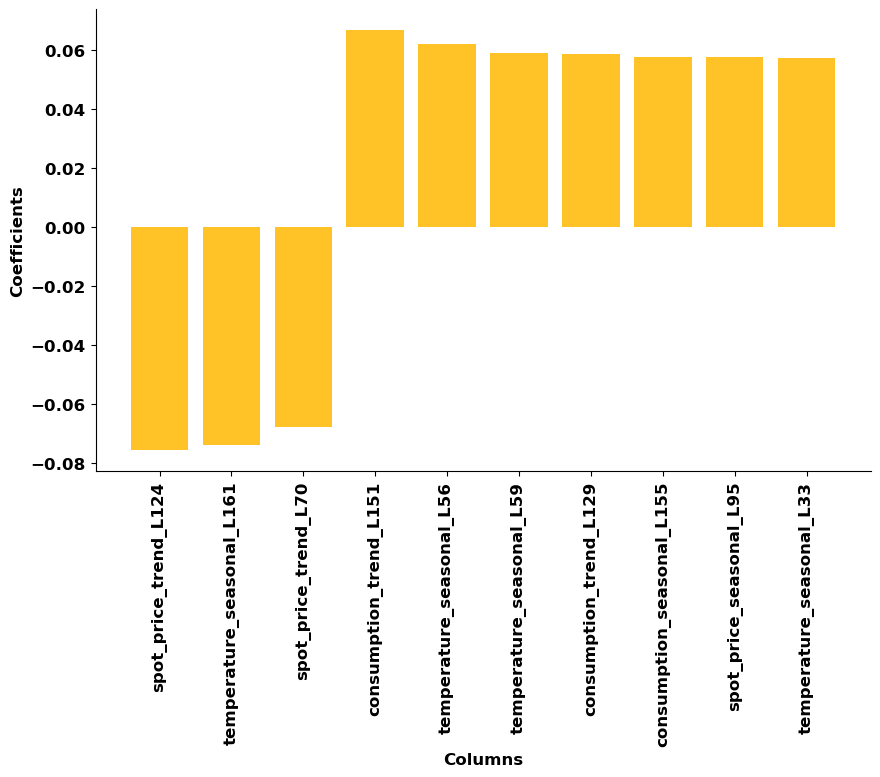

In [476]:
all_models = []
for I in range(5):
    data=DFS[I]
    print(DF_STRINGS[I])
    mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

    alpha1s = [2**(-20),2**(-18)]
    alpha2s = [2**(-12), 2**(-11), 2**(-10)]
    MAPEfacs = [0.1, 1, 10, 100]
    initVarianceFacs = [50, 100, 500]

    # Grid Search
    best_mape = float('inf')
    best_hyperparams = None

    print("Alpha1, alpha2, MAPEfac, initVarianceFac --> MAPE")
    for alpha1 in alpha1s:
        for alpha2 in alpha2s:
            for MAPEfac in MAPEfacs:
                for initVarianceFac in initVarianceFacs:
                    average_mape = cross_validate(data,alpha1,alpha2,mu,sig,MAPEfac,initVarianceFac)
                    print(f"{alpha1} {alpha2} {MAPEfac} {initVarianceFac} --> {average_mape}")
                    # Update best hyperparameters if current MAPE is lower
                    if average_mape < best_mape:
                        best_mape = average_mape
                        best_hyperparams = (alpha1,alpha2,MAPEfac,initVarianceFac)

    print(f'Best Hyperparameters: {best_hyperparams}')
    print(f'Best CV MAPE: {best_mape}%')

    
    X = data
    y1 = X["consumption_seasonal"]
    y2 = X["consumption_trend"]
    X = X.drop(columns=["consumption_seasonal", "consumption_trend"])

    thresh = np.floor(len(X) * (1 - VAL_SPLIT))
    X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
    y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
    y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)

    # Lasso with MAPE Loss
    def lasso_mape_loss(w, X, y_true, alpha):
   
        y_pred = X @ w
        return np.mean(soft_abs((y_true - y_pred)/(y_true+best_hyperparams[2]))) + alpha * np.sum(soft_abs(w))/np.mean(y_true+best_hyperparams[2])

    n_features = X_train.shape[1]
    w_initial = np.random.randn(n_features)/best_hyperparams[3] # Random initialize
    result = minimize(lasso_mape_loss, w_initial, args=(X_train, y1_train, best_hyperparams[0]), method='L-BFGS-B')
    w_optimal_1 = result.x
    y1_pred = X_val @ w_optimal_1

    result = minimize(lasso_mape_loss, w_initial, args=(X_train, y2_train, best_hyperparams[1]), method='L-BFGS-B')
    w_optimal_2 = result.x
    y2_pred = X_val @ w_optimal_2

    all_models.append([w_optimal_1, w_optimal_2])

    X = DFS[I]
    y1 = X["consumption_seasonal"]
    y2 = X["consumption_trend"]
    X = X.drop(columns=["consumption_seasonal", "consumption_trend"])

    train_pred1 = X_train @ w_optimal_1
    train_pred2 = X_train @ w_optimal_2

    actual = (y1 + y2)
    full_preds = np.concatenate(((train_pred1 + train_pred2).T,(y1_pred + y2_pred).T)).T
    mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

    # Create an array of indices for plotting
    xs = range(len(actual))
    xs_train = range(len(train_pred1))
    xs_oos = range(len(train_pred1),len(train_pred1)+len(y1_pred))

    # Plot actual values and predictions
    plt.figure(figsize=(10, 6))
    plt.plot(xs, actual * sig + mu, label='Actual Values', color='black', alpha=0.9)
    #plt.plot(xs_train, (train_pred1 + train_pred2) * sig + mu, label='In-sample predictions', color='#CFDDFF',alpha=0.9)
    plt.plot(xs_oos, (y1_pred + y2_pred) * sig + mu, label='Predicted Total', color='#FFC328', alpha=0.9)
    plt.plot(xs_oos, (y2_pred) * sig + mu, label='Predicted Trend', color='#47D779')
    plt.axvline(len(train_pred1), linestyle='--', color='black', label='Train/Validation Split')
    #plt.title(f"Lasso Predictions vs Actual Values - {DF_STRINGS[I]}")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    #plt.xlabel('Time')
    plt.xticks([])
    plt.yticks([])
    #plt.ylabel('Values')
    plt.legend()
    legend = plt.legend(fontsize='12')
    for text in legend.get_texts():
        text.set_fontweight('bold')
    plt.show()

    resids = ((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val)*sig+mu)
    oos_MAPE = np.mean(np.abs(resids)) * 100
    error_95 = np.percentile(np.abs(resids),95)
    print(f'Error95: {error_95}')
    mape_positive = resids[resids < 0].mean()*-100
    mape_negative = resids[resids > 0].mean()*100
    mape_trend = np.mean(np.abs(((y1_val+y2_val)*sig - (y2_pred)*sig) / ((y1_val+y2_val)*sig+mu)))*100
    print(f"Out of sample MAPE: {oos_MAPE}")
    print(f"Mean oveprediction: {mape_positive}")
    print(f"Mean underprediction: {mape_negative}")
    print(f"MAPE with trend prediction only: {mape_trend}")

    cols = X.columns
    coefs_total= (w_optimal_1+w_optimal_2)*sig
    print("Coefficients: ")
    for i in range(len(cols)):
        if np.abs(coefs_total[i])>0:
            print(f"{cols[i]}: {coefs_total[i]}")
    print(f"Number of features: {np.sum(np.where(np.abs(coefs_total)>0,1,0))}")

    combined_list = list(zip(cols, coefs_total))

    # Sorting by the absolute value of coefficients
    sorted_list = sorted(combined_list, key=lambda x: abs(x[1]), reverse=True)
    top_10 = sorted_list[:10]
    top_cols, top_coefs = zip(*top_10)
    plt.figure(figsize=(10, 6))
    plt.bar(top_cols, top_coefs, color='#FFC328')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    #plt.title(f"Top 10 Important Features by Coefficient - {DF_STRINGS[I]}")
    plt.xlabel('Columns', fontweight='bold', fontsize=12)
    plt.ylabel('Coefficients', fontweight='bold', fontsize=12)
    plt.xticks(rotation=90)  # Rotates the x-axis labels for better readability
    plt.xticks(fontweight='bold', fontsize=12)
    plt.yticks(fontweight='bold', fontsize=12)
    plt.show()


In [477]:
cross_table=np.zeros((5,5))
for I in range(5):
    for J in range(5):
        data = DFS[I]
        model1 = all_models[J][0]
        model1 = all_models[J][1]
        X = data
        y1 = X["consumption_seasonal"]
        y2 = X["consumption_trend"]
        X = X.drop(columns=["consumption_seasonal", "consumption_trend"])

        thresh = np.floor(len(X) * (1 - VAL_SPLIT))
        X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
        y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
        y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)

        model1.fit(X_train, y1_train)
        y1_pred = model1.predict(X_val)
        model2.fit(X_train, y2_train)
        y2_pred = model2.predict(X_val)
        mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

        resids = ((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val)*sig+mu)
        oos_MAPE = np.mean(np.abs(resids)) * 100
        cross_table[I,J]=oos_MAPE

df = pd.DataFrame(cross_table, index=DF_STRINGS, columns=DF_STRINGS)

# Create a heatmap using seaborn
sns.heatmap(df, cmap='viridis', annot=True, fmt=".2f", cbar=True)

# Set labels for the rows and columns with additional text
plt.xticks(np.arange(len(DF_STRINGS)) + 0.5, [f'{label} model' for label in DF_STRINGS], rotation=45)
plt.yticks(np.arange(len(DF_STRINGS)) + 0.5, [f'{label} location' for label in DF_STRINGS], rotation=0)

# Show the plot
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'fit'